In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from numpy import expand_dims,zeros,ones
from numpy.random import randn,randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal

In [2]:
IMAGE_SIZE = (28,28,1)
BATCH_SIZE = 200
STEPS = 500
EPOCHS = 20
LATENT_DIM = 100
N_CLASSES = 10

In [3]:
z_vis = tf.random.normal([10, LATENT_DIM])
y_vis = tf.constant(np.eye(10), dtype='float32')

In [4]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train / 255.0
y_train = tf.one_hot(y_train, depth=10, dtype='float32')
data_iter = iter(tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(4 * BATCH_SIZE).batch(BATCH_SIZE).repeat())

11493376/11490434 [==============================] - 0s 0us/step


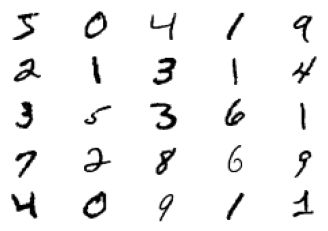

In [5]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')
plt.show()

In [6]:
def Generator():
    z = Input(shape=(LATENT_DIM,), dtype='float32')
    y = Input(shape=(10,), dtype='float32')

    x = Concatenate()([z, y])
    x = Dense(7 * 7 * 128)(x)
    x = Reshape((7, 7, 128))(x)

    x = Conv2DTranspose(128, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    out = Conv2DTranspose(1,  5, 1, 'same', activation='sigmoid')(x)
    #out = Reshape((28, 28,1))(x)

    return tf.keras.Model(inputs=[z, y], outputs=out)

In [7]:
def Discriminator():
    X = Input(shape=(28, 28), dtype='float32')
    Y = Input(shape=(10,), dtype='float32')

    y = tf.tile(tf.reshape(Y,[-1, 1, 1, 10]), [1, 28, 28, 1])
    x = Reshape((28, 28, 1))(X)
    x = Concatenate()([x, y])

    x = Conv2D(32,  5, 2, 'same')(x)

    x = Conv2D(64,  4, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(128,  3, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)

    out = Dense(1)(x)

    return tf.keras.Model(inputs=[X, Y], outputs=out)

In [8]:
G = Generator()
D = Discriminator()

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
def G_loss(D, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_fake, y])), D([x_fake, y]))
def D_loss(D, x_real, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_real, y])), D([x_real, y])) + cross_entropy(tf.zeros_like(D([x_fake, y])), D([x_fake, y]))

In [10]:
G_opt = Adam(2e-4,0.5)
D_opt = Adam(2e-4,0.5)

In [11]:
def generate_and_save_images(model, epoch, noise,label):
    predictions = model([noise,label])

    fig = plt.figure(figsize=(8, 2))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(model([noise,label])[i,:,:] * 255.0)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epoch: 1; G_loss: 0.830831; D_loss: 1.367226


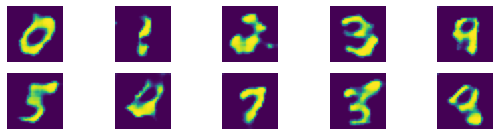

epoch: 2; G_loss: 1.452428; D_loss: 0.885323


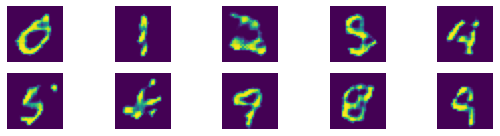

epoch: 3; G_loss: 1.145889; D_loss: 1.151189


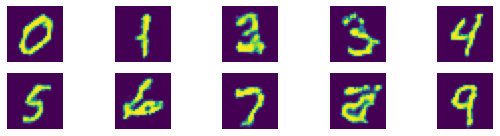

epoch: 4; G_loss: 0.963098; D_loss: 1.013850


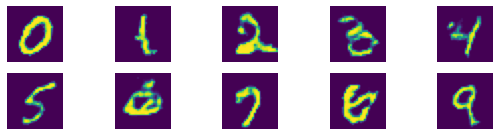

epoch: 5; G_loss: 1.159946; D_loss: 1.104196


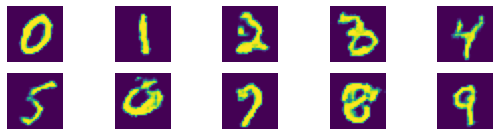

epoch: 6; G_loss: 1.205069; D_loss: 1.096566


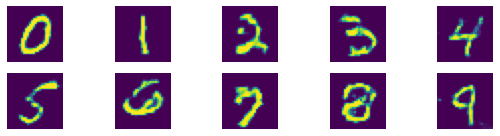

epoch: 7; G_loss: 0.874864; D_loss: 1.277293


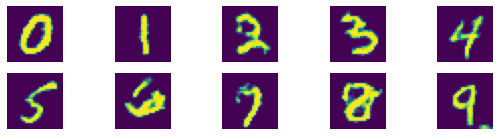

epoch: 8; G_loss: 0.859949; D_loss: 1.241437


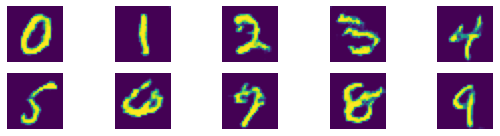

epoch: 9; G_loss: 0.853150; D_loss: 1.233890


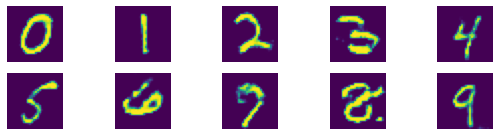

epoch: 10; G_loss: 0.852647; D_loss: 1.287610


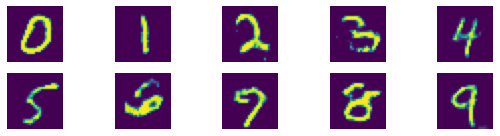

epoch: 11; G_loss: 0.861402; D_loss: 1.171297


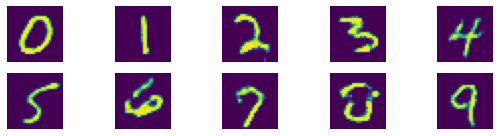

epoch: 12; G_loss: 0.855072; D_loss: 1.253529


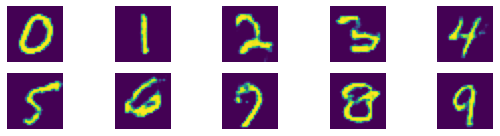

epoch: 13; G_loss: 0.829368; D_loss: 1.298774


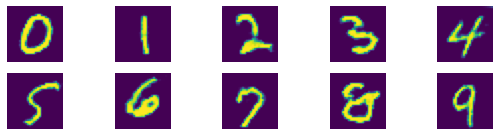

epoch: 14; G_loss: 0.882522; D_loss: 1.349413


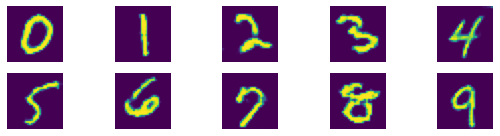

epoch: 15; G_loss: 0.830051; D_loss: 1.227587


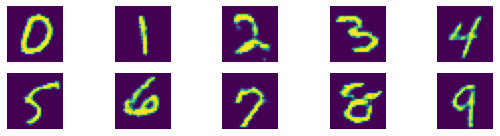

epoch: 16; G_loss: 0.871423; D_loss: 1.298132


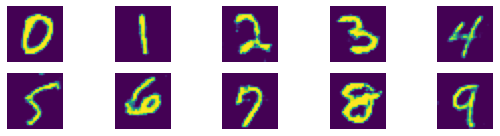

epoch: 17; G_loss: 0.800790; D_loss: 1.326477


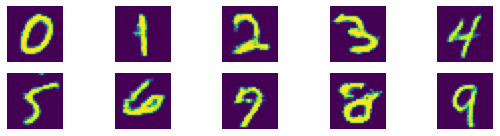

epoch: 18; G_loss: 0.826469; D_loss: 1.221874


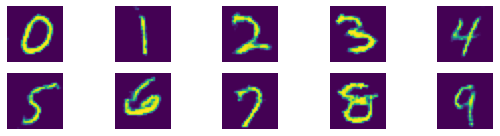

epoch: 19; G_loss: 0.711805; D_loss: 1.333219


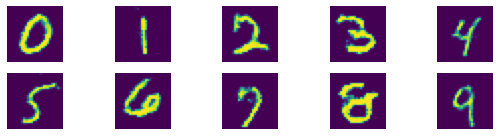

epoch: 20; G_loss: 0.775229; D_loss: 1.306747


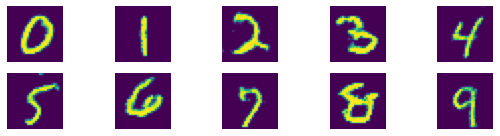

In [12]:
for epoch in range(EPOCHS):
    for step in range(STEPS):
        z_mb = tf.random.normal([BATCH_SIZE, LATENT_DIM])
        x_real, y = next(data_iter)
        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:  
            x_fake = G([z_mb, y])
            G_loss_curr = G_loss(D, x_fake, y)
            D_loss_curr = D_loss(D, x_real, x_fake, y)

        G_grad = G_tape.gradient(G_loss_curr, G.trainable_variables)
        D_grad = D_tape.gradient(D_loss_curr, D.trainable_variables)

        G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
        D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    
    print('epoch: {}; G_loss: {:.6f}; D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
    generate_and_save_images(G,epoch,z_vis,y_vis)

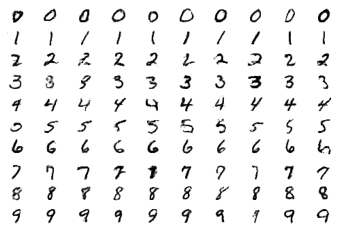

In [13]:
new_noise = tf.random.normal([100, LATENT_DIM])
labels = np.asarray([np.eye(10)[i//10] for i in range(100)])
pred = G([new_noise,labels])
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(pred[i, :, :], cmap='gray_r')
plt.show()

In [14]:
fp_in = "./image_*.png"
fp_out = "./MNIST_training.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=50, loop=0)

In [15]:
G.save('mnist_gen.hdf5')
D.save('mnist_dis.hdf5')